# The Modified Henry Problem

In [149]:
import numpy as np
import pandas as pd
import xarray as xr
import imod
import os
import matplotlib.pyplot as plt
import subprocess

#Defining some functions
def quick_plot(in_array,titl):
    '''Function for quickly plotting 2D cross section of xarray data for visualising/QC'''
    
    in2d=in_array.isel(y=0)
    fig, axs = plt.subplots(figsize=(8,4))
    fig.suptitle(titl)
    return xr.plot.plot(in2d,yincrease=False,ax=axs,)

Verifying numerical codes against a standard analytical solution is a key step to ensuring the validity
of numerical simulations. The verification of density-dependent flow models is challenging due to the
limited availability of analytical solutions and standard test cases (Simmons et al., 1999). The Henry
saltwater intrusion problem has been widely used to benchmark numerical codes that are capable
of simulating density driven fluid flow (Simpson and Clement, 2003; Voss and Souza, 1987). 

The problem considers a vertical slice through a confined coastal aquifer with homogeneous and isotropic properties. A constant influx of fresh water was applied to the landward boundary of the aquifer, with higher density seawater resting at the seaward boundary. The upper and lower boundaries of the domain were assigned constant Neumann boundary conditions representing a confined system.
The domain and boundary conditions are summarized in the following figure.

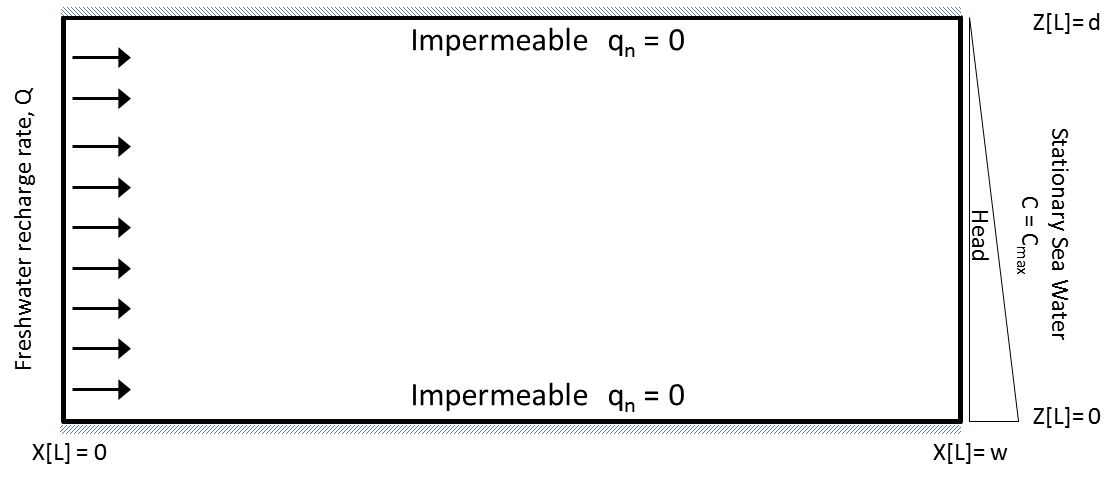

The study by Henry (1964) presents a semi-analytical solution for the steady-state distribution of
salt concentration in the confined, saturated porous medium. The Henry problem has been long
discussed in literature (Segol, 1994; Lee and Cheng, 1974; Pinder and Cooper, 1970) and a number
of modifications suggested in the decades since its proposal. In this section, the modified version
of Henry’s problem presented by Simpson and Clement (2004) is reproduced using imod-python and imod-WQ
and the results compared to verify the capability of the numerical code to model density driven flow
in a porous medium.

## Aquifer and model properties

Properties used in this modified henry problem are taken from the study titled **Improving the worthiness of the Henry problem as a benchmark for density-dependent groundwater flow models** by Simpson and Clement (2004). Available online here: https://doi.org/10.1029/2003WR002199  

## Discretization

In [304]:
#No. of cells in each direction
nrow = 1  #horizontal axis 
ncol = 100 #horizontal axis 
nlay = 50 # the vertical axis

# Size of cells in each of the axes
dz = 1.0
dx = 1.0
dy = -dx

top1D = xr.DataArray(
    np.arange(nlay * dz, 0.0, -dz), {"layer": np.arange(1, 1 + nlay)}, ("layer")
)
bot = top1D - 1.0

In [305]:
#Freshwater recharge rate
q=3.3e-05 # units of m/s
qscaled=q*86400*(dz * abs(dy)) # Converted to units of m/day for imod-WQ algorithm

#Porosity
por=35.0 

#Hydraulic Conductivity
hyd_k= 1.0e-03 # units of (m/s)
hyd_k_md=hyd_k*86400 # units of (m/day)
hyd_k_md

86.4

## Defining Initial and Boundary Conditions

In [306]:
# Defining the IBOUND array for imod, which denotes the active cells in the model 
# by assigning a value of 1. 

bnd = xr.DataArray(
    data=np.full((nlay, nrow, ncol), 1.0),
    coords={
        "y": [0.5],
        "x": np.arange(0.5 * dx, dx * ncol, dx),
        "layer": np.arange(1, 1 + nlay),
        "dx": dx,
        "dy": dy,
    },
    dims=("layer", "y", "x"),
)

# Boundary Conditions
# -------------------
# The Henry problem is prescribed by a constant head boundary condition on the right model boundary,
# which represents a static ocean interface. This is denoted in imod by assigning a value of -1 to the
# boundary cells

bnd[:, :, -1] = -1 # The head at the right boundary will remain fixed at the initial value.
# Boundary condition - Freshwater recharge rate

#--------------------

# Initial Condition
#--------------------
# The model domain is initialized with freshwater in all cells, except for the right model boundary cells.
# These are initialised at 35.0 g/L.

iconc = xr.DataArray(
    data=np.full((nlay, nrow, ncol), 0.0),
    coords={
        "y": [0.5],
        "x": np.arange(0.5 * dx, dx * ncol, dx),
        "layer": np.arange(1, 1 + nlay),
        "dx": dx,
        "dy": dy,
    },
    dims=("layer", "y", "x"),
)
# Assigning initial value of 35.0 g/L to right model boundary
iconc[:, :, -1] = 35.0
# -------------------



# Defining layers 

In this section, up to three layers can be defined within the model domain.
We achieve simply by multiplying the hydraulic conductivity by user defined factors to increase or decrease the value relative to the earlier defined value.

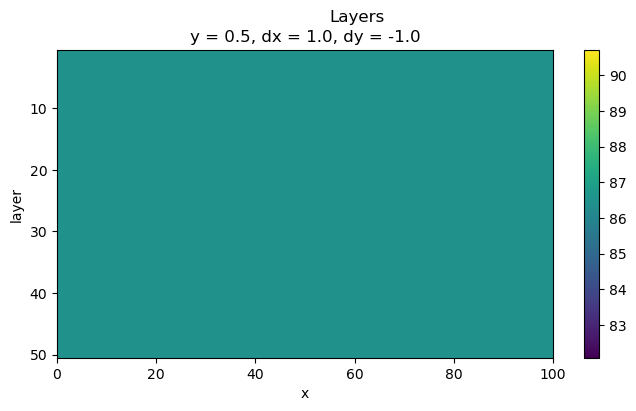

In [307]:
# Creating an array of ones with the same dimensions of the model domain
mod_array=np.full((nlay, nrow, ncol), 1.0)

# Defining layer geometry within model domain
#Layer 1
top_l1=0
base_l1=25
#Layer 2
top_l2=25
base_l2=50

#Assigning hydraulic conductivity 
hyd_k_l=hyd_k_md*mod_array
hyd_k_layered = xr.DataArray(
    data=hyd_k_l,
    coords={
        "y": [0.5],
        "x": np.arange(0.5 * dx, dx * ncol, dx),
        "layer": np.arange(1, 1 + nlay),
        "dx": dx,
        "dy": dy,
    },
    dims=("layer", "y", "x"),
)
hyd_k_layered[top_l1:base_l1,0,:]*=1
hyd_k_layered[top_l2:base_l2,0,:]*=1

#Assigning porosity
por_l=por*mod_array
por_layered = xr.DataArray(
    data=por,
    coords={
        "y": [0.5],
        "x": np.arange(0.5 * dx, dx * ncol, dx),
        "layer": np.arange(1, 1 + nlay),
        "dx": dx,
        "dy": dy,
    },
    dims=("layer", "y", "x"),
)

por_layered[top_l1:base_l1,0,:]=60
por_layered[top_l2:base_l2,0,:]=40

quick_plot(hyd_k_layered,'Layers')


## Creating WEL Package

In [308]:
# The well package is used in imod to prescribe freshwater injection at the model boundary cells
nlay=1
#creating 50 well names
wells=[0]*nlay
for i in range(nlay):
    wells[i]="well{}".format(i)

#Creating the well data    
weldata = pd.DataFrame()
weldata["x"] = 0.5*(np.ones(nlay))
weldata["y"] = 0.5*(np.ones(nlay))
weldata["q"] = 0.1*(qscaled)*(np.ones(nlay))
weldata["layer"] = np.arange(1.0,nlay+1,1)
weldata

,x,y,q,layer
0,0.5,0.5,0.28512,1.0


## Building the model

For more information: https://deltares.gitlab.io/imod/imod-python/api/index.htmlhttps://deltares.gitlab.io/imod/imod-python/api/wq.html#

In [315]:
m = imod.wq.SeawatModel("Henry")
m["bas"] = imod.wq.BasicFlow(ibound=bnd, top=50.0, bottom=bot, starting_head=50.0) #saturated 
m["lpf"] = imod.wq.LayerPropertyFlow(
    k_horizontal=hyd_k_layered, k_vertical=hyd_k_layered , specific_storage=1.0)
m["btn"] = imod.wq.BasicTransport(
    icbund=bnd, starting_concentration=iconc, porosity=por)
m["adv"] = imod.wq.AdvectionTVD(courant=1.0)
m["dsp"] = imod.wq.Dispersion(longitudinal=2.0, diffusion_coefficient=1.886e-05)
m["vdf"] = imod.wq.VariableDensityFlow(density_concentration_slope=0.71)

# In the Henry problem, the flux rate is applied to each cell of the left boundary.
# Therefore, a well is defined for each layer cell in the left boundary i.e. 1 per layer

m["wel"] = imod.wq.Well(id_name=wells, x=weldata["x"], y=weldata["y"], 
                            rate=weldata["q"])#,layer=weldata["layer"])    

m["pcg"] = imod.wq.PreconditionedConjugateGradientSolver(
    max_iter=150, inner_iter=30, hclose=1.0e-6, rclose=1.0, relax=0.98, damp=1.0
)
m["gcg"] = imod.wq.GeneralizedConjugateGradientSolver(
    max_iter=150,
    inner_iter=30,
    cclose=1.0e-6,
    preconditioner="mic",
    lump_dispersion=True,
)
m["oc"] = imod.wq.OutputControl(save_head_idf=True, save_concentration_idf=True,save_budget_idf=True)

m.time_discretization(times=pd.date_range("2000-01-01", "2010-01-01", freq="Y"))

mods_dir = "Models/henry"
res_dir = os.path.join(mods_dir,"results")
m.write(directory=mods_dir, result_dir=res_dir)

In [316]:
#####WINDOWS##########################
#    #Writing the windows batch script
with open('runmod.bat','w') as infile:
    infile.write("#! /bin/bash \n")
    infile.write("cd Models/henry \n")
    infile.write("C:/Users/User/WORK-PC-LOCAL/AquaInfra-local/imod_files/iMODexe/iMOD-WQ_V5_3_SVN359_X64R.exe Henry.run")
infile.close()


Text(0.5, 0, 'Distance (m)')

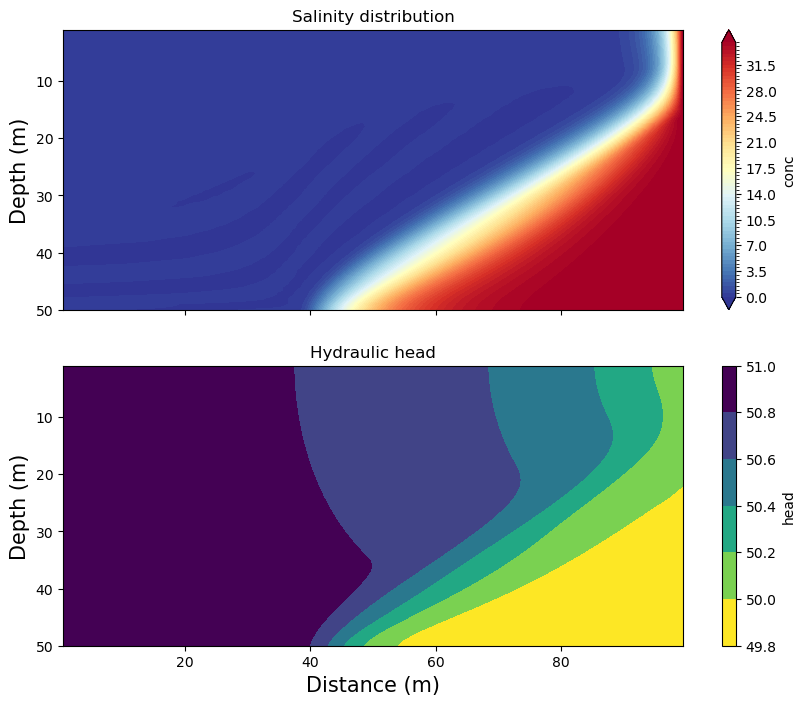

In [318]:
#date=200112310000
date=200612310000
ts=0
sect=0
na=1e-30
naconc=1e30
fsz=15
#read data from idf
conc=imod.idf.open("Models/henry/results/conc/conc_{}_l*.IDF".format(date))
#masking inactive cells
conc=xr.where(conc==naconc,np.nan,conc)
#head
head=imod.idf.open("Models/henry/results/head/head_{}_l*.idf".format(date))
#masking inactive cells
head=xr.where((head==na),np.nan,head)

fig, axs = plt.subplots(2,figsize=(10,8),sharex=True)

conc[ts,:,sect,:].plot.contourf(y="layer",yincrease=False, ax=axs[0],
                                levels=np.arange(0.0,35.0,0.5),
                                cmap="RdYlBu_r")
#conc[ts,:,sect,:].plot.contour(y="layer",yincrease=False, ax=axs[0],
#                                levels=[35*0.25,35*0.5,35*0.75,35*0.90],cmap="k",linestyles="dashed")
axs[0].set_ylabel("Depth (m)",fontsize=fsz)
#axs[0].set_yticklabels(5*np.arange(0,50,10))
axs[0].set_xlabel(" ")
axs[0].set_title("Salinity distribution")


head[ts,:,sect,:].plot.contourf(y="layer", yincrease=False,ax=axs[1],
                                cmap="viridis_r")
axs[1].set_title("Hydraulic head")
axs[1].set_ylabel("Depth (m)",fontsize=fsz)
#axs[1].set_yticklabels(5*np.arange(0,50,10))
axs[1].set_xlabel("Distance (m)",fontsize=fsz)

# Sensitivity tests

- Anisotropy
- Porosity
- Layer geometry
- Diffusion coefficient
- 